Deep Learning Assignment 3 

References:
Code source 1: https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

Code source 2 (TODO: find how to get predictions accuracy): https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch


In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import torch
import torch.nn as nn
import os
import yfinance as yf
import os, contextlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# folder_path = '/content/drive/MyDrive/deep_learning/'
# print(os.listdir(folder_path))

# hist_dir = folder_path + 'hist'

# if not os.path.exists(hist_dir):
#     print('dir not exists so creating one')
#     os.mkdir(hist_dir)
# else:
#     print('directory exists ', hist_dir)


In [4]:
# configs
offset = 0
limit = 3000
period = 'max' # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

# download all NASDAQ traded symbols

# data = pd.read_csv("http://www.nasdaqtrader.com/dynamic/SymDir/nasdaqtraded.txt", sep='|')
# data_clean = data[data['Test Issue'] == 'N']
# symbols = data_clean['NASDAQ Symbol'].tolist()
# print('total number of symbols traded = {}'.format(len(symbols)))



In [5]:
symbols = ['AAPL','AMZN','META']

In [6]:
print(symbols)

['AAPL', 'AMZN', 'META']


In [7]:
limit = limit if limit else len(symbols)
end = min(offset + limit, len(symbols))
is_valid = [False] * len(symbols)
# force silencing of verbose API
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        for i in range(offset, end):
            s = symbols[i]
            data = yf.download(s, period=period)
            if len(data.index) == 0:
                continue
        
            is_valid[i] = True
            file_name = s + ".csv"
            # download_path = os.path.join(root_dir,file_name)
            data.to_csv(file_name)

print('Total number of valid symbols downloaded = {}'.format(sum(is_valid)))

Total number of valid symbols downloaded = 3


In [8]:
# valid_data = data_clean[is_valid]
# valid_data.to_csv('symbols_valid_meta.csv', index=False)



In [9]:
# !mkdir stocks
# !mkdir etfs

In [10]:
# etfs = valid_data[valid_data['ETF'] == 'Y']['NASDAQ Symbol'].tolist()
# stocks = valid_data[valid_data['ETF'] == 'N']['NASDAQ Symbol'].tolist()

In [11]:
# import shutil
# from os.path import isfile, join

# def move_symbols(symbols, dest):
#     for s in symbols:
#         filename = '{}.csv'.format(s)
#         shutil.move(join('hist', filename), join(dest, filename))
        
# move_symbols(etfs, "etfs")
# move_symbols(stocks, "stocks")

In [12]:

data = pd.read_csv('AMZN.csv', index_col='Date')
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...
2022-11-07,91.949997,92.099998,89.040001,90.529999,90.529999,77495700
2022-11-08,90.790001,91.720001,88.230003,89.980003,89.980003,88703400
2022-11-09,89.470001,89.480003,85.870003,86.139999,86.139999,90796200


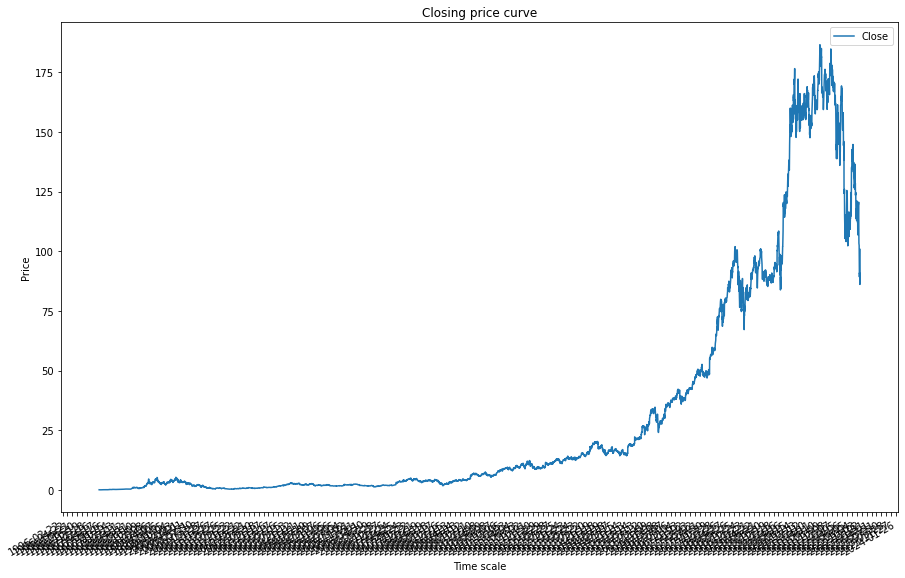

In [114]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in data.index.values]

plt.plot(x_dates, data['Close'], label='Close')
# plt.plot(x_dates, data['Low'], label='Low')
plt.xlabel('Time scale')
plt.ylabel('Price')
plt.title('Closing price curve')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [14]:
# X_features = data[['Open','High','Low']]
# X_features

In [15]:
# y_labels = data[['Close']]
# y_labels

In [16]:
# # feature scaling
# standard_scaler = StandardScaler()
# x_scaled = standard_scaler.fit_transform(X_features)
# x_df = pd.DataFrame(columns=X_features.columns, data = x_scaled, index = X_features.index)
# x_df

In [92]:
price = data[['Close']]
price

,Close
Date,
1997-05-15,0.097917
1997-05-16,0.086458
1997-05-19,0.085417
1997-05-20,0.081771
1997-05-21,0.071354
...,...
2022-11-07,90.529999
2022-11-08,89.980003
2022-11-09,86.139999


In [111]:
# price_values = price.values
# price_values  =price_values.reshape(price_values.shape[0])
# price_values.shape
# price_list =list(price_values)
# price_list[0]
# # type(price_list)

In [110]:
# plt.plot(range(len(price)), price_list)

In [18]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
price

,Close
Date,
1997-05-15,-0.999698
1997-05-16,-0.999821
1997-05-19,-0.999832
1997-05-20,-0.999872
1997-05-21,-0.999983
...,...
2022-11-07,-0.029921
2022-11-08,-0.035819
2022-11-09,-0.076999


In [20]:

def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [21]:
# def split_data_into_steps(data_to_split, steps):
#     X = []
#     y = []
#     for i in range(len(data_to_split) - steps + 1):
#         X.append(data_to_split[i:i + steps, :-1])
#         y.append(data_to_split[i + steps - 1, -1])

#     return np.array(X), np.array(y)

In [22]:
# def split_data_into_train_test(X, y, split_size, date_index):
#     split_idx = int(np.ceil(len(X) * split_size))
    
#     X_train = X[:split_idx]
#     X_test = X[split_idx:]
#     y_train = y[:split_idx].reshape(-1,1)
#     y_test = y[split_idx:].reshape(-1,1)

#     X_train_date = date_index[:split_idx]
#     X_test_date = date_index[split_idx:]

#     return X_train, X_test, y_train, y_test, X_train_date, X_test_date

In [23]:
# X,y = split_data_into_steps(data.values, 2)
# X_train, X_test, y_train, y_test, X_train_date, X_test_date = split_data_into_train_test(X, y, 0.8, data.index)
# print('X.shape ', X.shape)
# print('X_train.shape ', X_train.shape)
# print('X_test.shape ', X_test.shape)
# print('y_train.shape ', y_train.shape)
# print('y_test.shape ', y_test.shape)

In [24]:

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [25]:
print(x_train.shape)
# print(x_train)

torch.Size([5118, 19, 1])


In [66]:
def train_network(num_epochs, model, criterion, optimiser, x_train, y_train):
    results = []
    # hist = np.zeros(num_epochs)
    start_time = time.time()
    lstm = []
    for t in range(num_epochs):
        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train)
        loss_value_train = loss.item()
        print("Epoch ", t, "MSE: ", loss_value_train)
        # hist[t] = loss.item()
        # loss_value = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        results.append({'epoch': t, 'train_loss': loss_value_train})

    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    return results

In [76]:
def plot_loss_curve(train_results,  title):
    epochs = []
    loss_values =  []
    for r in train_results:
        epochs.append(r['epoch'])
        loss_values.append(r['train_loss'])
    plt.plot(epochs, loss_values)
    plt.title(title + ' Loss curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss  value')
    plt.show()
    

,Close
Date,
1997-05-15,-0.999698
1997-05-16,-0.999821
1997-05-19,-0.999832
1997-05-20,-0.999872
1997-05-21,-0.999983
...,...
2022-11-07,-0.029921
2022-11-08,-0.035819
2022-11-09,-0.076999


In [69]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # print('out shape ', out.shape)
        out = self.fc(out[:, -1, :]) 
        return out

input_dim  1
Epoch  0 MSE:  1.1145890951156616
Epoch  1 MSE:  0.8225799798965454
Epoch  2 MSE:  0.5225822925567627
Epoch  3 MSE:  0.1495623141527176
Epoch  4 MSE:  0.10373226553201675
Epoch  5 MSE:  0.15151873230934143
Epoch  6 MSE:  0.061064038425683975
Epoch  7 MSE:  0.015415877103805542
Epoch  8 MSE:  0.023494228720664978
Epoch  9 MSE:  0.04497368261218071
Training time: 4.183656454086304


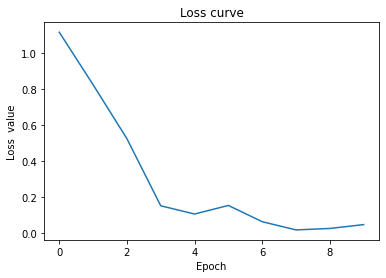

In [72]:
input_dim = x_train.shape[2]
print('input_dim ', input_dim)
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10
learning_rate = 0.01
model_lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_lstm.parameters(), lr= learning_rate)
train_results = train_network(num_epochs, model_lstm, criterion, optimiser, x_train, y_train_lstm)
plot_loss_curve(train_results, 'LSTM')

In [29]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

Epoch  0 MSE:  0.865327000617981
Epoch  1 MSE:  0.3667895197868347
Epoch  2 MSE:  0.06547009944915771
Epoch  3 MSE:  0.05532516539096832
Epoch  4 MSE:  0.1349274218082428
Epoch  5 MSE:  0.0513402558863163
Epoch  6 MSE:  0.00904292706400156
Epoch  7 MSE:  0.03379792720079422
Epoch  8 MSE:  0.06162906810641289
Epoch  9 MSE:  0.06196833774447441
Training time: 3.4808056354522705


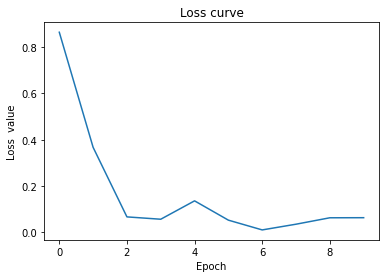

In [74]:
model_gru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_gru.parameters(), lr=learning_rate)
train_results = train_network(num_epochs, model_gru, criterion, optimiser, x_train, y_train)
plot_loss_curve(train_results, 'GRU')

In [33]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.rnn(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

Epoch  0 MSE:  0.7964843511581421
Epoch  1 MSE:  0.15540039539337158
Epoch  2 MSE:  0.06447222083806992
Epoch  3 MSE:  0.08491308242082596
Epoch  4 MSE:  0.0108391884714365
Epoch  5 MSE:  0.05963480472564697
Epoch  6 MSE:  0.054819270968437195
Epoch  7 MSE:  0.018711458891630173
Epoch  8 MSE:  0.014181381091475487
Epoch  9 MSE:  0.03259025886654854
Training time: 0.8744914531707764


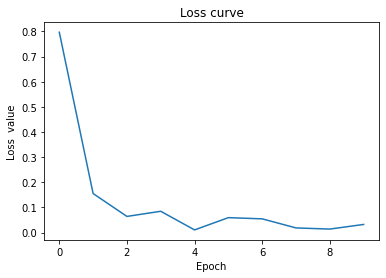

In [75]:
model_rnn = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)
train_results = train_network(num_epochs, model_rnn, criterion, optimiser, x_train, y_train)
plot_loss_curve(train_results, 'RNN')

Learning rate =  0.1
Epoch  0 MSE:  0.6237923502922058
Epoch  1 MSE:  0.19131729006767273
Epoch  2 MSE:  1.3117761611938477
Epoch  3 MSE:  1.8092821836471558
Epoch  4 MSE:  16.227157592773438
Epoch  5 MSE:  4.188508033752441
Epoch  6 MSE:  3.702991485595703
Epoch  7 MSE:  0.8751067519187927
Epoch  8 MSE:  0.031794071197509766
Epoch  9 MSE:  0.9290366768836975
Epoch  10 MSE:  0.14129604399204254
Epoch  11 MSE:  0.36101821064949036
Epoch  12 MSE:  0.3529793322086334
Epoch  13 MSE:  0.14915043115615845
Epoch  14 MSE:  0.018736127763986588
Training time: 1.326542854309082


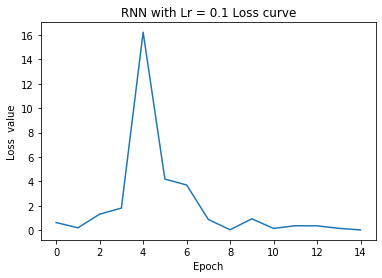

Learning rate =  0.01
Epoch  0 MSE:  0.8503121137619019
Epoch  1 MSE:  0.1647813320159912
Epoch  2 MSE:  0.07499711215496063
Epoch  3 MSE:  0.14747704565525055
Epoch  4 MSE:  0.042528558522462845
Epoch  5 MSE:  0.023443715646862984
Epoch  6 MSE:  0.07366373389959335
Epoch  7 MSE:  0.05217595398426056
Epoch  8 MSE:  0.018820788711309433
Epoch  9 MSE:  0.014899840578436852
Epoch  10 MSE:  0.027675561606884003
Epoch  11 MSE:  0.03476564213633537
Epoch  12 MSE:  0.029222644865512848
Epoch  13 MSE:  0.01888645999133587
Epoch  14 MSE:  0.014045601710677147
Training time: 1.35099458694458


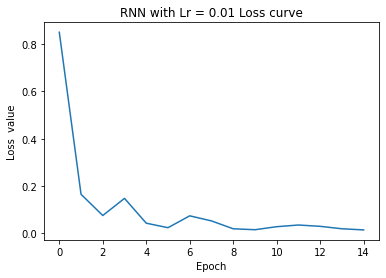

Learning rate =  0.001
Epoch  0 MSE:  0.643222987651825
Epoch  1 MSE:  0.5502309799194336
Epoch  2 MSE:  0.46130266785621643
Epoch  3 MSE:  0.3771834373474121
Epoch  4 MSE:  0.29895704984664917
Epoch  5 MSE:  0.22779373824596405
Epoch  6 MSE:  0.16493239998817444
Epoch  7 MSE:  0.11163210868835449
Epoch  8 MSE:  0.06910736113786697
Epoch  9 MSE:  0.038351837545633316
Epoch  10 MSE:  0.01981860026717186
Epoch  11 MSE:  0.013013855554163456
Epoch  12 MSE:  0.016120346263051033
Epoch  13 MSE:  0.02587137743830681
Epoch  14 MSE:  0.038054365664720535
Training time: 1.3220300674438477


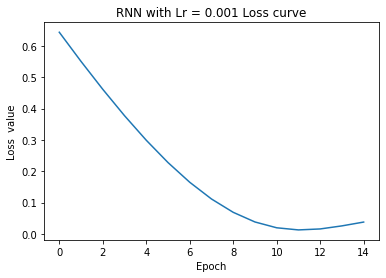

Learning rate =  0.0001
Epoch  0 MSE:  0.8532350659370422
Epoch  1 MSE:  0.8449146747589111
Epoch  2 MSE:  0.8366148471832275
Epoch  3 MSE:  0.8283364176750183
Epoch  4 MSE:  0.8200799822807312
Epoch  5 MSE:  0.8118460178375244
Epoch  6 MSE:  0.8036348223686218
Epoch  7 MSE:  0.7954465746879578
Epoch  8 MSE:  0.7872812747955322
Epoch  9 MSE:  0.7791388630867004
Epoch  10 MSE:  0.7710191011428833
Epoch  11 MSE:  0.7629218101501465
Epoch  12 MSE:  0.75484699010849
Epoch  13 MSE:  0.7467945218086243
Epoch  14 MSE:  0.7387641668319702
Training time: 1.615807056427002


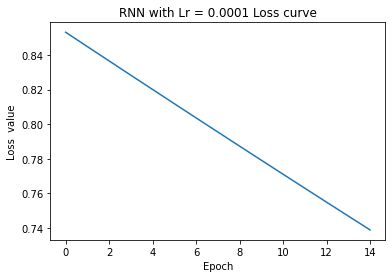

,lr,mse,train_results
1,0.0100,0.014046,"[{'epoch': 0, 'train_loss': 0.8503121137619019..."
0,0.1000,0.018736,"[{'epoch': 0, 'train_loss': 0.6237923502922058..."
2,0.0010,0.038054,"[{'epoch': 0, 'train_loss': 0.643222987651825}..."
3,0.0001,0.738764,"[{'epoch': 0, 'train_loss': 0.8532350659370422..."


In [86]:
# Learning rate tuning for RNN model
num_epochs = 15
lr_results = []
for lr in [0.1, 0.01,  0.001,  0.0001]:
    print('Learning rate = ', lr)
    model_rnn = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model_rnn.parameters(), lr=lr)
    train_results = train_network(num_epochs, model_rnn, criterion, optimiser, x_train, y_train)
    plot_loss_curve(train_results, 'RNN with Lr = ' + str(lr))
    # get last mse
    last_mse = [result['train_loss'] for result in  train_results if result['epoch']  == num_epochs  - 1][0]
    lr_results.append({'lr': lr, 'mse': last_mse, 'train_results': train_results})

lr_results_df = pd.DataFrame(lr_results)
lr_results_df.sort_values(by="mse", ascending=True)

Learning rate =  0.1
Epoch  0 MSE:  0.6374721527099609
Epoch  1 MSE:  3.8876919746398926
Epoch  2 MSE:  0.42325645685195923
Epoch  3 MSE:  0.16160467267036438
Epoch  4 MSE:  0.017067817971110344
Epoch  5 MSE:  0.13153016567230225
Epoch  6 MSE:  0.15794220566749573
Epoch  7 MSE:  0.0904245674610138
Epoch  8 MSE:  0.033697694540023804
Epoch  9 MSE:  0.018288280814886093
Epoch  10 MSE:  0.03612056374549866
Epoch  11 MSE:  0.025734934955835342
Epoch  12 MSE:  0.015559181571006775
Epoch  13 MSE:  0.02320137619972229
Epoch  14 MSE:  0.027265887707471848
Training time: 6.460925102233887


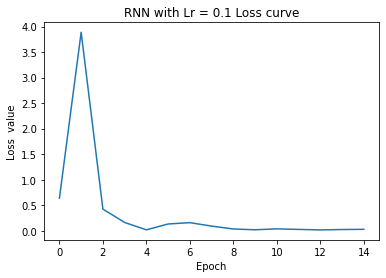

Learning rate =  0.01
Epoch  0 MSE:  0.9336367845535278
Epoch  1 MSE:  0.7188867926597595
Epoch  2 MSE:  0.48173537850379944
Epoch  3 MSE:  0.1771538406610489
Epoch  4 MSE:  0.0217445008456707
Epoch  5 MSE:  0.17766322195529938
Epoch  6 MSE:  0.12094473838806152
Epoch  7 MSE:  0.041792336851358414
Epoch  8 MSE:  0.014380949549376965
Epoch  9 MSE:  0.024752506986260414
Epoch  10 MSE:  0.04261203110218048
Epoch  11 MSE:  0.051646530628204346
Epoch  12 MSE:  0.05037369206547737
Epoch  13 MSE:  0.0424702912569046
Epoch  14 MSE:  0.03218156844377518
Training time: 6.866665840148926


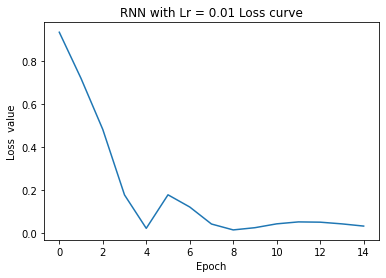

Learning rate =  0.001
Epoch  0 MSE:  0.5069724917411804
Epoch  1 MSE:  0.48562705516815186
Epoch  2 MSE:  0.46468356251716614
Epoch  3 MSE:  0.4438899755477905
Epoch  4 MSE:  0.4231257438659668
Epoch  5 MSE:  0.40230509638786316
Epoch  6 MSE:  0.3813389837741852
Epoch  7 MSE:  0.36014050245285034
Epoch  8 MSE:  0.3386298418045044
Epoch  9 MSE:  0.31673380732536316
Epoch  10 MSE:  0.2943846583366394
Epoch  11 MSE:  0.2715209424495697
Epoch  12 MSE:  0.24809333682060242
Epoch  13 MSE:  0.22407427430152893
Epoch  14 MSE:  0.19947239756584167
Training time: 7.149503469467163


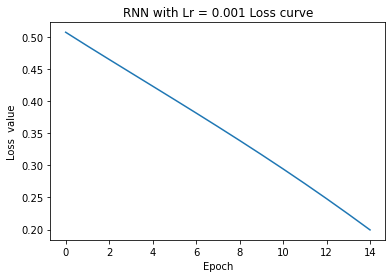

Learning rate =  0.0001
Epoch  0 MSE:  0.8745563626289368
Epoch  1 MSE:  0.8714807033538818
Epoch  2 MSE:  0.8684088587760925
Epoch  3 MSE:  0.8653407692909241
Epoch  4 MSE:  0.8622762560844421
Epoch  5 MSE:  0.8592153191566467
Epoch  6 MSE:  0.8561579585075378
Epoch  7 MSE:  0.8531038761138916
Epoch  8 MSE:  0.8500526547431946
Epoch  9 MSE:  0.847004234790802
Epoch  10 MSE:  0.8439580798149109
Epoch  11 MSE:  0.840913712978363
Epoch  12 MSE:  0.8378707766532898
Epoch  13 MSE:  0.834828794002533
Epoch  14 MSE:  0.8317872881889343
Training time: 7.045902490615845


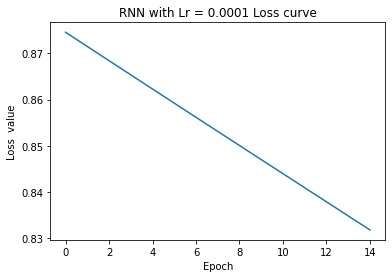

,lr,mse,train_results
0,0.1000,0.027266,"[{'epoch': 0, 'train_loss': 0.6374721527099609..."
1,0.0100,0.032182,"[{'epoch': 0, 'train_loss': 0.9336367845535278..."
2,0.0010,0.199472,"[{'epoch': 0, 'train_loss': 0.5069724917411804..."
3,0.0001,0.831787,"[{'epoch': 0, 'train_loss': 0.8745563626289368..."


In [87]:
# Learning rate tuning for LSTM model
num_epochs = 15
lr_results = []
for lr in [0.1, 0.01,  0.001,  0.0001]:
    print('Learning rate = ', lr)
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    train_results = train_network(num_epochs, model, criterion, optimiser, x_train, y_train)
    plot_loss_curve(train_results, 'RNN with Lr = ' + str(lr))
    # get last mse
    last_mse = [result['train_loss'] for result in  train_results if result['epoch']  == num_epochs  - 1][0]
    lr_results.append({'lr': lr, 'mse': last_mse, 'train_results': train_results})

lr_results_df = pd.DataFrame(lr_results)
lr_results_df.sort_values(by="mse", ascending=True)

Learning rate =  0.1
Epoch  0 MSE:  0.7806419134140015
Epoch  1 MSE:  3.502342462539673
Epoch  2 MSE:  1.1534231901168823
Epoch  3 MSE:  0.37238264083862305
Epoch  4 MSE:  0.9952492117881775
Epoch  5 MSE:  10.697014808654785
Epoch  6 MSE:  2.2529854774475098
Epoch  7 MSE:  0.5570039749145508
Epoch  8 MSE:  0.23643165826797485
Epoch  9 MSE:  0.09453309327363968
Epoch  10 MSE:  0.3646044433116913
Epoch  11 MSE:  0.09227915853261948
Epoch  12 MSE:  0.027337877079844475
Epoch  13 MSE:  0.08142167329788208
Epoch  14 MSE:  0.02586216852068901
Training time: 5.804396629333496


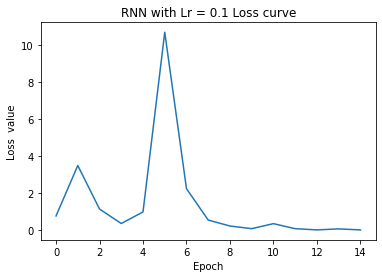

Learning rate =  0.01
Epoch  0 MSE:  0.7991613149642944
Epoch  1 MSE:  0.3235669434070587
Epoch  2 MSE:  0.03624558821320534
Epoch  3 MSE:  0.12719948589801788
Epoch  4 MSE:  0.12339473515748978
Epoch  5 MSE:  0.029202546924352646
Epoch  6 MSE:  0.01415292639285326
Epoch  7 MSE:  0.04637475684285164
Epoch  8 MSE:  0.06569038331508636
Epoch  9 MSE:  0.05889494717121124
Epoch  10 MSE:  0.03788845241069794
Epoch  11 MSE:  0.01806235872209072
Epoch  12 MSE:  0.0099750692024827
Epoch  13 MSE:  0.015131916850805283
Epoch  14 MSE:  0.025664072483778
Training time: 5.531306028366089


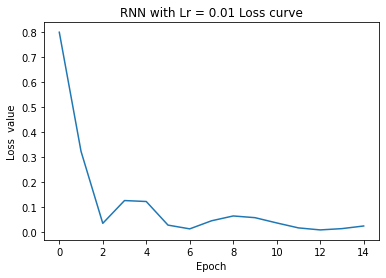

Learning rate =  0.001
Epoch  0 MSE:  0.594494640827179
Epoch  1 MSE:  0.5424798727035522
Epoch  2 MSE:  0.492352694272995
Epoch  3 MSE:  0.44408655166625977
Epoch  4 MSE:  0.397643506526947
Epoch  5 MSE:  0.35298576951026917
Epoch  6 MSE:  0.31007784605026245
Epoch  7 MSE:  0.2689223885536194
Epoch  8 MSE:  0.22958435118198395
Epoch  9 MSE:  0.19220277667045593
Epoch  10 MSE:  0.1570008099079132
Epoch  11 MSE:  0.12429648637771606
Epoch  12 MSE:  0.09451089054346085
Epoch  13 MSE:  0.06816988438367844
Epoch  14 MSE:  0.045892003923654556
Training time: 5.132084608078003


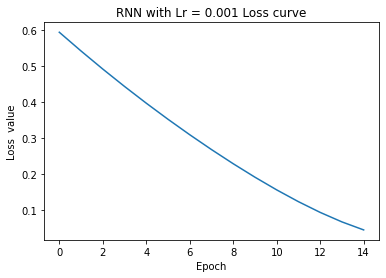

Learning rate =  0.0001
Epoch  0 MSE:  1.2418826818466187
Epoch  1 MSE:  1.2337037324905396
Epoch  2 MSE:  1.2255606651306152
Epoch  3 MSE:  1.217454195022583
Epoch  4 MSE:  1.2093846797943115
Epoch  5 MSE:  1.2013527154922485
Epoch  6 MSE:  1.193358063697815
Epoch  7 MSE:  1.1854013204574585
Epoch  8 MSE:  1.1774823665618896
Epoch  9 MSE:  1.1696007251739502
Epoch  10 MSE:  1.1617565155029297
Epoch  11 MSE:  1.15394926071167
Epoch  12 MSE:  1.1461783647537231
Epoch  13 MSE:  1.1384433507919312
Epoch  14 MSE:  1.1307436227798462
Training time: 5.061620235443115


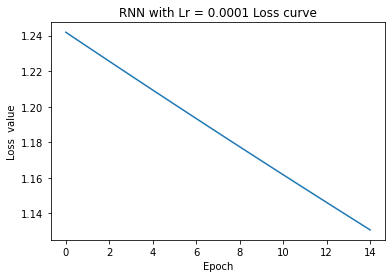

,lr,mse,train_results
1,0.0100,0.025664,"[{'epoch': 0, 'train_loss': 0.7991613149642944..."
0,0.1000,0.025862,"[{'epoch': 0, 'train_loss': 0.7806419134140015..."
2,0.0010,0.045892,"[{'epoch': 0, 'train_loss': 0.594494640827179}..."
3,0.0001,1.130744,"[{'epoch': 0, 'train_loss': 1.2418826818466187..."


In [88]:
# Learning rate tuning for GRU model
num_epochs = 15
lr_results = []
for lr in [0.1, 0.01,  0.001,  0.0001]:
    print('Learning rate = ', lr)
    model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    train_results = train_network(num_epochs, model, criterion, optimiser, x_train, y_train)
    plot_loss_curve(train_results, 'RNN with Lr = ' + str(lr))
    # get last mse
    last_mse = [result['train_loss'] for result in  train_results if result['epoch']  == num_epochs  - 1][0]
    lr_results.append({'lr': lr, 'mse': last_mse, 'train_results': train_results})

lr_results_df = pd.DataFrame(lr_results)
lr_results_df.sort_values(by="mse", ascending=True)

In [82]:
r = []
r.append({'epoch':1,  'val':  123})
r.append({'epoch':2, 'val': 43})

last_r = [rval['val']  for rval in r if rval['epoch'] == 2]
last_r[0]

43